# SIFT: Scale Invariant Feature Transform

Extract features that are invariant towards:
* image scale
* rotation

partially invariant towards:
* afine distortion
* changes in 3D viewpoint
* noise
* change in illumination

## Major steps of the algorithm

* __1.) Scale-space extrema detection:__ Search over all scales and image locations, efficient, using DoG, to identify potential interest points that are invariant to scale and orientation
* __2.) Keypoint localization:__ At each found candidate location, a more detailed model is extracted to determine location and scale.
* __3.) Orientation assignment:__ One or more orientations are assigned to each keypoint, based on local image gradient.
* __4.) Keypoint descriptor:__ local image gradient is measured at the selected scale and location. These are transformed into a representation.

In [6]:
# do all the import stuff
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import cv2
import math
import pandas
from scipy import signal, ndimage, misc, gradient

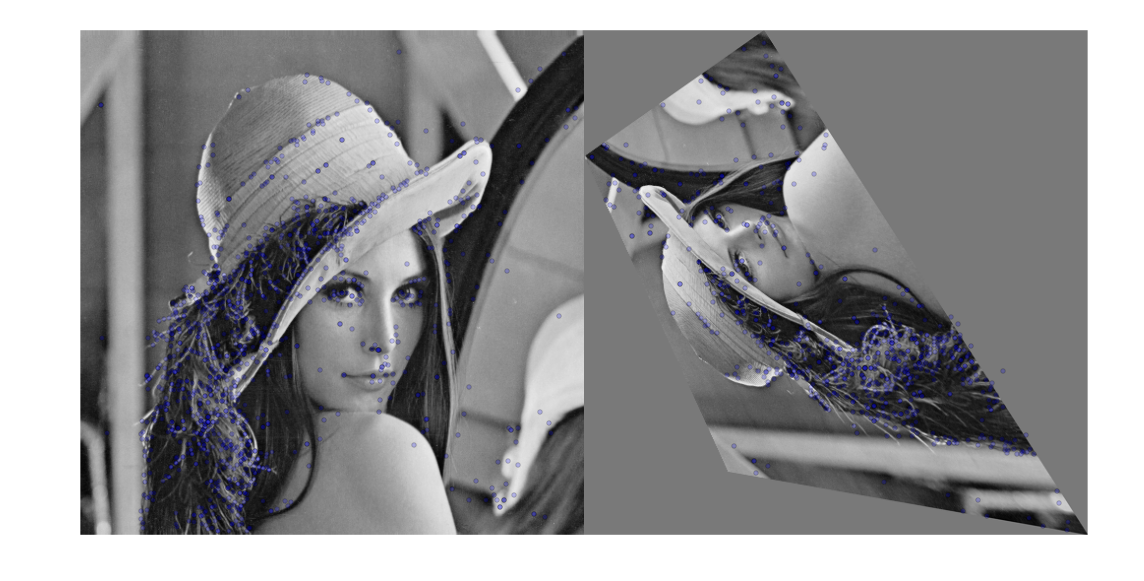

In [7]:
locs = pandas.read_csv("locs_Lenna.csv", header=None).as_matrix() 
locs_trans = pandas.read_csv("locs_Lenna_transformed.csv", header=None).as_matrix()

I = cv2.imread('Lenna.png').astype(np.float32)/255.0
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

I_trans = cv2.imread('Lenna_transformed.png').astype(np.float32)/255.0
I_trans = cv2.cvtColor(I_trans, cv2.COLOR_BGR2GRAY)

I_comb = np.hstack((I, I_trans))


f, ax = plt.subplots(ncols=1)
f.set_size_inches(16, 16)

ax.imshow(I_comb, cmap=plt.get_cmap('gray'))

ax.scatter(locs[:, 1] + 0, locs[:, 0], alpha=.2)
ax.scatter(locs_trans[:, 1] + I.shape[1], locs_trans[:, 0], alpha=.2)

plt.axis("off")
plt.tight_layout()
plt.show()

## Detection of scale-space extrema

Detect keypoints by using a cascade filtering to identify candidate locations for further examination.
Identify locations and scales that can be repeatably assigned under different views of the same object. $\Rightarrow$ Detect locations that are invariant to scale change can be accomplished by searching for stable features accross all possible scales, using a continuous function of scale known as scale space.

The only possible scale-space kernel is the Gaussian function $G$ (WHY?),
therefor the scale space of an image is defined as:

$$ L(x,y,\sigma) = G(x,y,\sigma)*I(x,y)$$

where $*$ is the convolution in $x$ and $y$ and

$$G(x,y,\sigma)=\frac{1}{2\pi\sigma^2}e^{-(x^2+y^2)/2\sigma^2}$$.

To efficiently detect stable keypoints in scale space one can use scale-space extrema in the DoG function convolved with the image, $D(x,y,\sigma)$, where $k$ is a constant multiplicative factor:

$$D(x,y,\sigma)=(G(x,y,k\sigma)-G(x,y,\sigma))*I(x,y)=L(x,y,k\sigma)-L(x,y,\sigma)$$

Derivations:

$$ k = [1, -1] $$
$$ D_x = D*k $$
$$ D_y = D*k^T$$
$$ D_{xx} = D*k*k$$
$$ D_{yy} = D*k^T*k^T$$

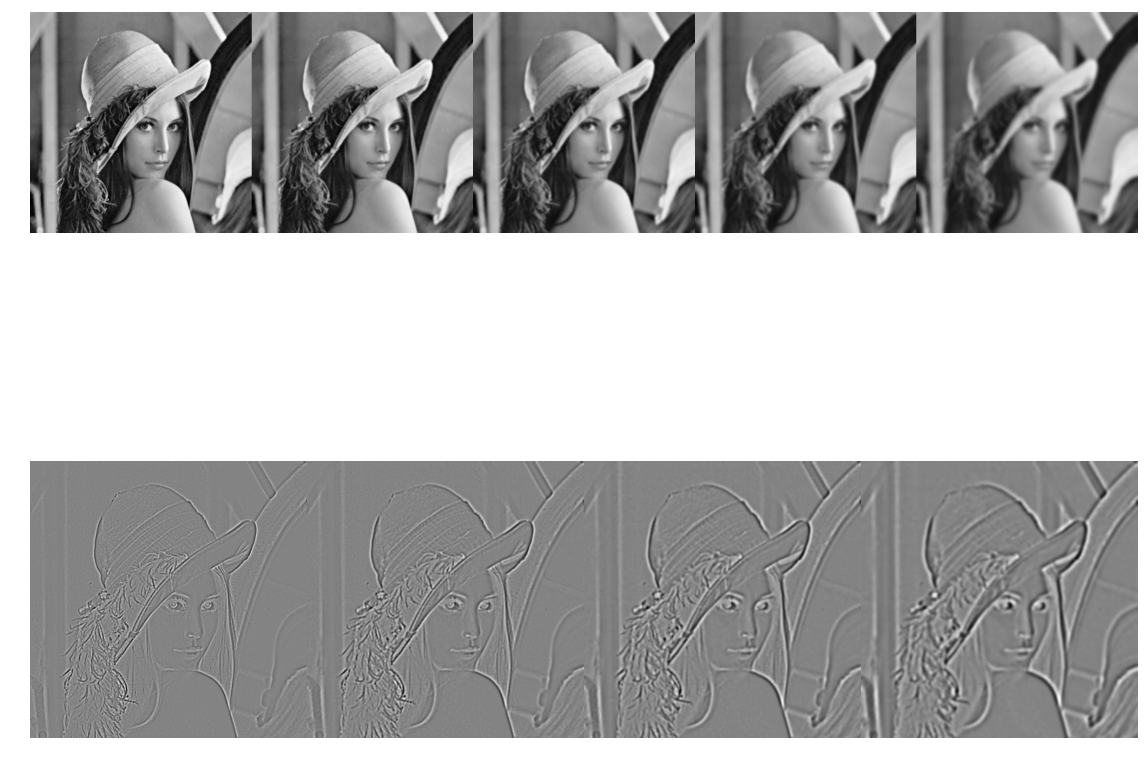

In [26]:
def sobel_transform(I):
    image = I.astype(np.float32) / np.max(I)
    Gy = ndimage.filters.sobel(image, axis=0)
    Gx = ndimage.filters.sobel(image, axis=1)
    M = np.hypot(Gx, Gy)
    A = np.arctan2(Gy, Gx)
    return M, A

class Octave(object):
    S = 2
    _g = None
    _d = None
    
    DoG = None
    Gauss = None
    
    local_max = None
    local_min = None
    
    DoG_gradient = None
    
    level = -1
    
    def __init__(self, I, octave_level):
        self.DoG = []
        self.Gauss = []
        self.level = octave_level
        scale = []
        k = 2**(1.0/ self.S)
        for i in range(0, self.S + 3):
            sigma = k ** i
            G = ndimage.filters.gaussian_filter(
                I, sigma, order=0, output=None,
                mode='reflect', cval=0.0, truncate=4.0)
            scale.append(G)
            self.Gauss.append(G)
            
        gaussian = []
        for i in range(0, self.S + 2):
            dog = scale[i+1] - scale[i]
            gaussian.append(dog)
            self.DoG.append(dog)
        
        self._d = np.hstack(gaussian)
        self._g = np.hstack(scale)

    def dogs_gradient(self):
        if self.DoG_gradient is None:
            self.DoG_gradient = []
            for dog in self.DoG:
                dx, dy = gradient(dog)
                self.DoG_gradient.append((dx, dy))
        return self.DoG_gradient
        
    def local_extrema(self):
        """
        return the maximum and minimum extremas, build up like:
        [y, x, scale-level]
        """
        if self.local_max is None or self.local_min is None:
            w = self.DoG[0].shape[1]
            h = self.DoG[0].shape[0]
            max_candidates = []
            min_candidates = []
            for i in range(1, len(self.DoG)-1):
                for x in range(1, w-2):
                    for y in range(1, h-2):
                        v = abs(self.DoG[i][y,x])
                        if v > 0.03:  # magic value
                            Bottom = self.DoG[i-1][y-1:y+1,x-1:x+1]
                            Top = self.DoG[i+1][y-1:y+1,x-1:x+1]
                            Plane = self.DoG[i][y-1:y+1,x-1:x+1]
                            maxim = max(
                                max(np.max(Bottom), np.max(Top)), np.max(Plane))
                            minim = min(
                                min(np.min(Bottom), np.min(Top)), np.min(Plane))
                            c = [y, x, i, 0]
                            if math.isclose(maxim, Plane[1,1]):
                                if not self.eliminating_edge_response(c):
                                    self.add_orientation(c)
                                    max_candidates.append(c)
                            elif math.isclose(minim, Plane[1,1]):
                                if not self.eliminating_edge_response(c):
                                    self.add_orientation(c)
                                    min_candidates.append(c)
            self.local_min = np.array(min_candidates)
            self.local_max = np.array(max_candidates)
        return self.local_max, self.local_min    

    def add_orientation(self, extrema):
        [x, y, s, _] = extrema
        window = self.Gauss[s][(y-4):(y+5),(x-4):(x+5)]
        if window.shape != (9, 9):
            extrema[3] = 0.0
        else:
            M, A = sobel_transform(window)
            # histo:
            # tbd
            extrema[3] = A[4,4]
            
        
        
    def eliminating_edge_response(self, candidate):
        [x, y, s, _] = candidate
        
        D_x, D_y = self.dogs_gradient()[s]
        
        D_xx = (D_x[y,  x -1] - D_x[y, x + 1]) / 2.0
        D_yy = (D_y[y - 1, x] - D_y[y + 1, x]) / 2.0
        D_xy = (D_x[y - 1, x] - D_x[y + 1, x]) / 2.0
        D_yx = (D_y[y, x - 1] - D_y[y, x + 1]) / 2.0
    
    
        trace = D_xx + D_yy
        det   = D_xx * D_yy - D_yx * D_yx
        ratio = -((trace * trace) / det)
        
        if ratio < 1.0:  # threshold ratio
            return True
    
        return False
    
octa = Octave(I, 1)

f, (ax, ay) = plt.subplots(ncols=1, nrows=2)
f.set_size_inches(16, 16)

ax.imshow(octa._g, cmap=plt.get_cmap('gray'))
ay.imshow(octa._d, cmap=plt.get_cmap('gray'))

ay.axis("off")
ax.axis('off')
plt.tight_layout()
plt.show()

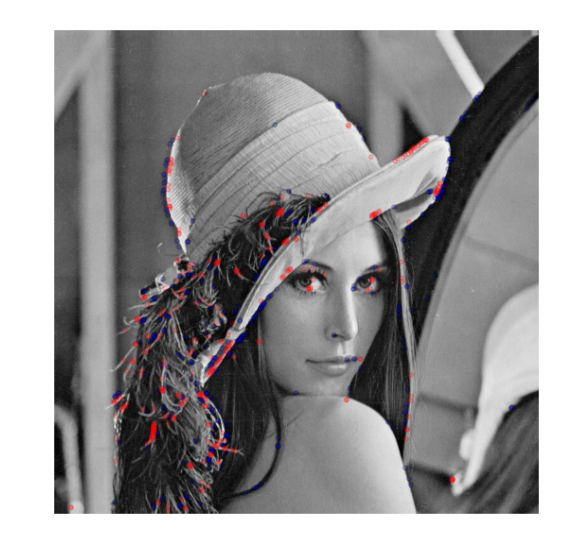

In [9]:
ma, mi = octa.local_extrema()
max_x = ma[:,1]
max_y = ma[:,0]
min_x = mi[:,1]
min_y = mi[:,0]


f, ax = plt.subplots(ncols=1, nrows=1)
f.set_size_inches(8, 8)
ax.imshow(I, cmap=plt.get_cmap('gray'))
ax.axis('off')
ax.scatter(max_x, max_y, alpha=.2)
ax.scatter(min_x, min_y, alpha=.2, color='red')
plt.tight_layout()
plt.show()


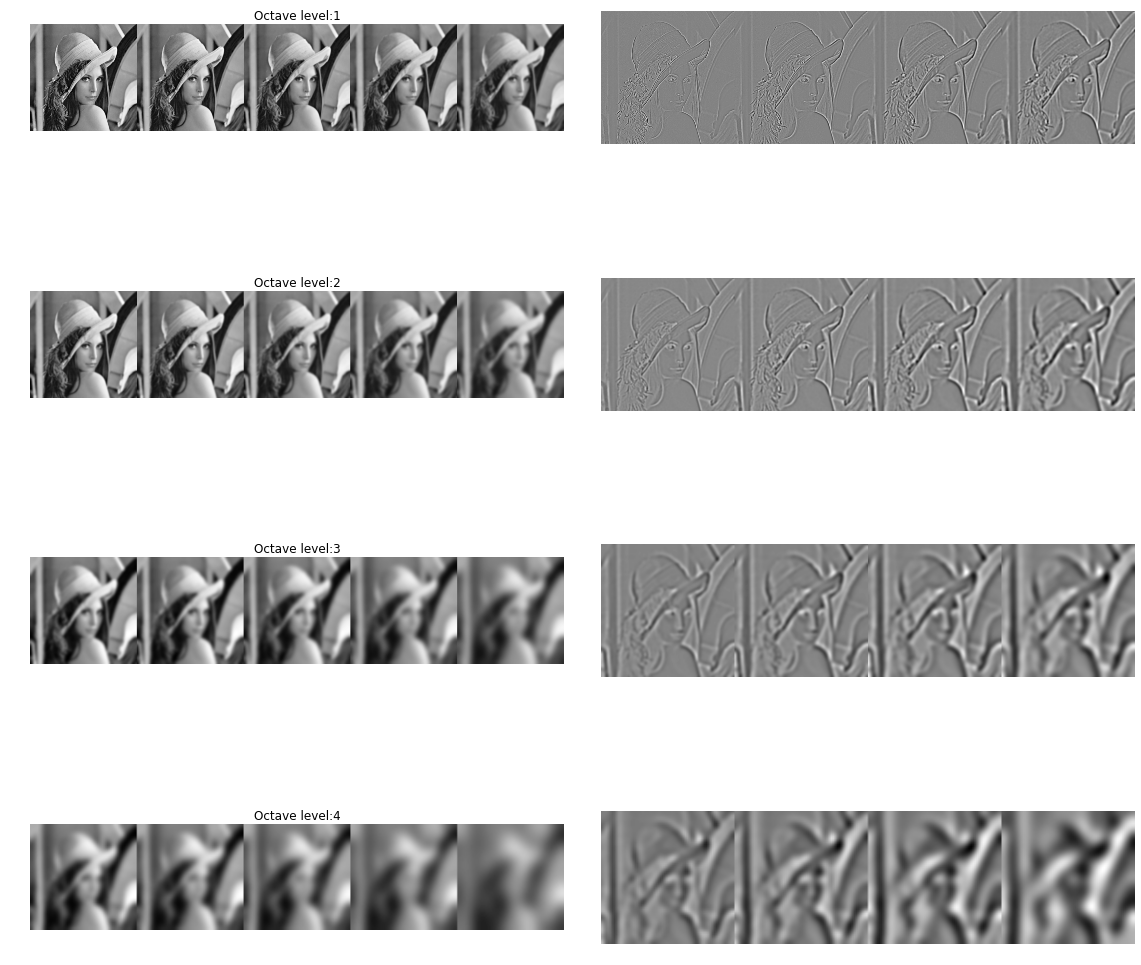

In [37]:
# Scale space
class ScaleSpace(object):
    octaves = None
    original = None
    
    def __init__(self, I):
        Im = I.copy()
        self.original = I.copy()
        self.octaves = []
        octave = Octave(Im, 1)
        self.octaves.append(octave)
        level = 2
        while Im.shape[0] > 64:
            Im = octave.Gauss[-3]
            Im = misc.imresize(Im, 0.5).astype(np.float32) / 255.0
            octave = Octave(Im, level)
            level += 1
            self.octaves.append(octave)
            
    def draw_extrema(self, draw_dir=False):
        """
        draw the extrema regarding to their octave
        """
        f, axs = plt.subplots(ncols=1, nrows=1)
        f.set_size_inches(16, 8)
        I = self.original
        
        for i, octa in enumerate(self.octaves):
            ma, mi = octa.local_extrema()
            extr = np.concatenate((ma, mi), axis=0)
            X = extr[:,1] * 2**(octa.level-1)
            Y = extr[:,0] * 2**(octa.level-1)
            D = extr[:,3]
            R = 1.0
            U, V = R * np.sin(D), R * np.cos(D)
            
            for j in range(X.shape[0]):
                x = X[j]
                y = Y[j]
                d = D[j]
                f.gca().add_artist(plt.Circle((x, y), 2**(i), color='r', fill=False))
            
            
            Q = axs.quiver(X, Y, U, V, color='b')
            
        axs.axis('off')
        axs.imshow(I, cmap=plt.get_cmap('gray'))
        plt.tight_layout()
        plt.show()
            
    def draw(self):
        """
        Draw the scale space
        """
        f, axs = plt.subplots(ncols=2, nrows=len(self.octaves))
        f.set_size_inches(16, 16)
        
        for i in range(len(self.octaves)):
            octa = self.octaves[i]
            axs[i][0].imshow(octa._g, cmap=plt.get_cmap('gray'))
            axs[i][1].imshow(octa._d, cmap=plt.get_cmap('gray'))
            axs[i][0].set_title("Octave level:" + str(octa.level))
            axs[i][0].axis('off')
            axs[i][1].axis('off')

        plt.tight_layout()
        plt.show()
            
ss = ScaleSpace(I)
ss.draw()

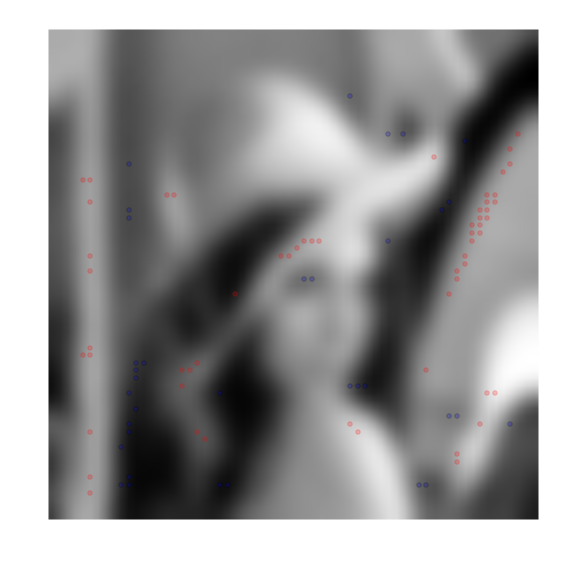

In [11]:
ss = ScaleSpace(I)
octa = ss.octaves[-1]
ma, mi = octa.local_extrema()
max_x = ma[:,1]
max_y = ma[:,0]
min_x = mi[:,1]
min_y = mi[:,0]


f, ax = plt.subplots(ncols=1, nrows=1)
f.set_size_inches(8, 8)
ax.imshow(octa.Gauss[0], cmap=plt.get_cmap('gray'))
ax.axis('off')
ax.scatter(max_x, max_y, alpha=.2)
ax.scatter(min_x, min_y, alpha=.2, color='red')
plt.tight_layout()
plt.show()

# Aufgabe 1

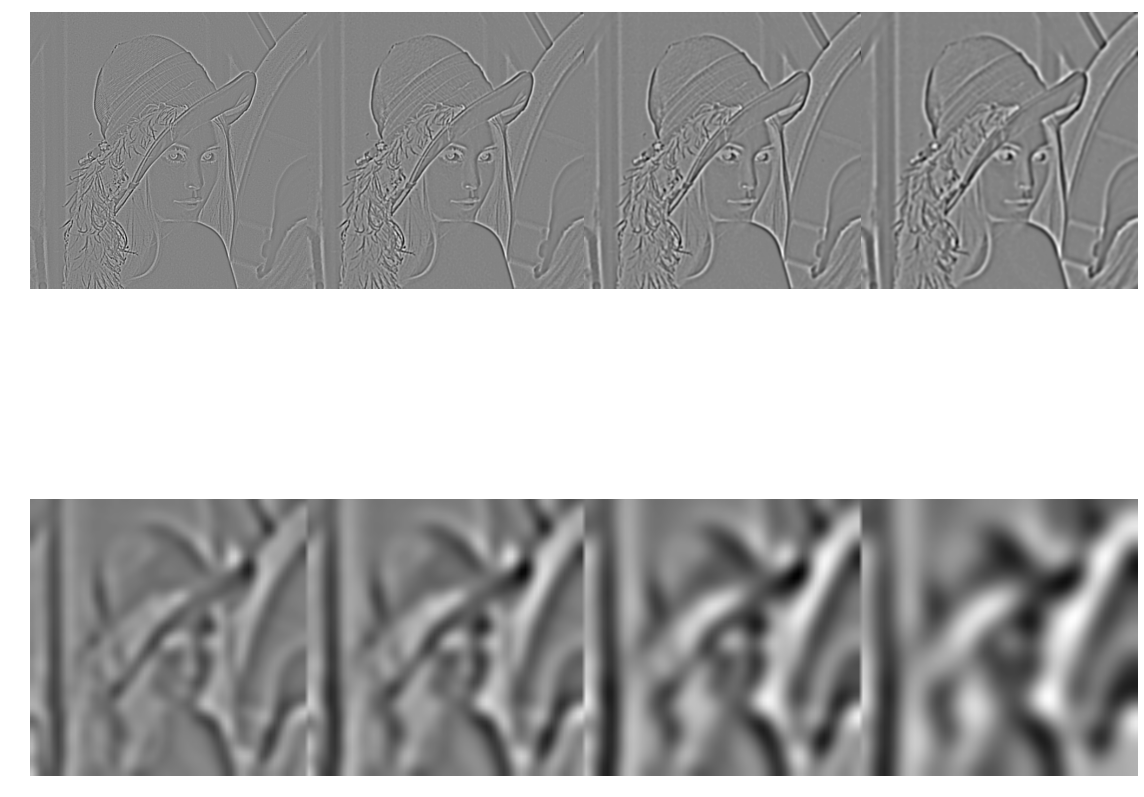

In [12]:
ss = ScaleSpace(I)
First = ss.octaves[0]
Last = ss.octaves[-1]

f, (ax,ay) = plt.subplots(ncols=1, nrows=2)
f.set_size_inches(16, 16)
ax.imshow(First._d, cmap=plt.get_cmap('gray'))
ax.axis('off')
ay.imshow(Last._d, cmap=plt.get_cmap('gray'))
ay.axis('off')
plt.tight_layout()
plt.show()

# Aufgabe 2

(782, 4)
(311, 4)
(124, 4)
(92, 4)


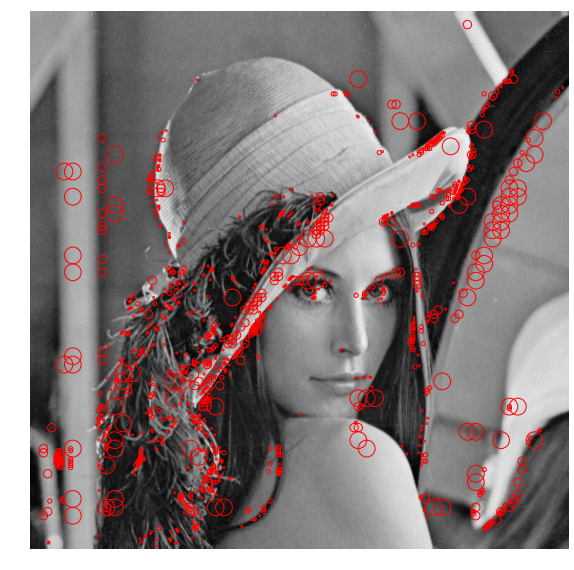

In [13]:
ss = ScaleSpace(I)
ss.draw_extrema()

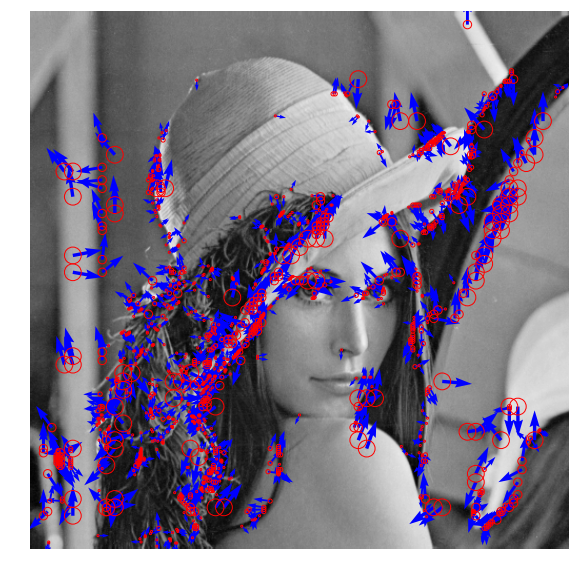

In [38]:
ss = ScaleSpace(I)
ss.draw_extrema(draw_dir=True)

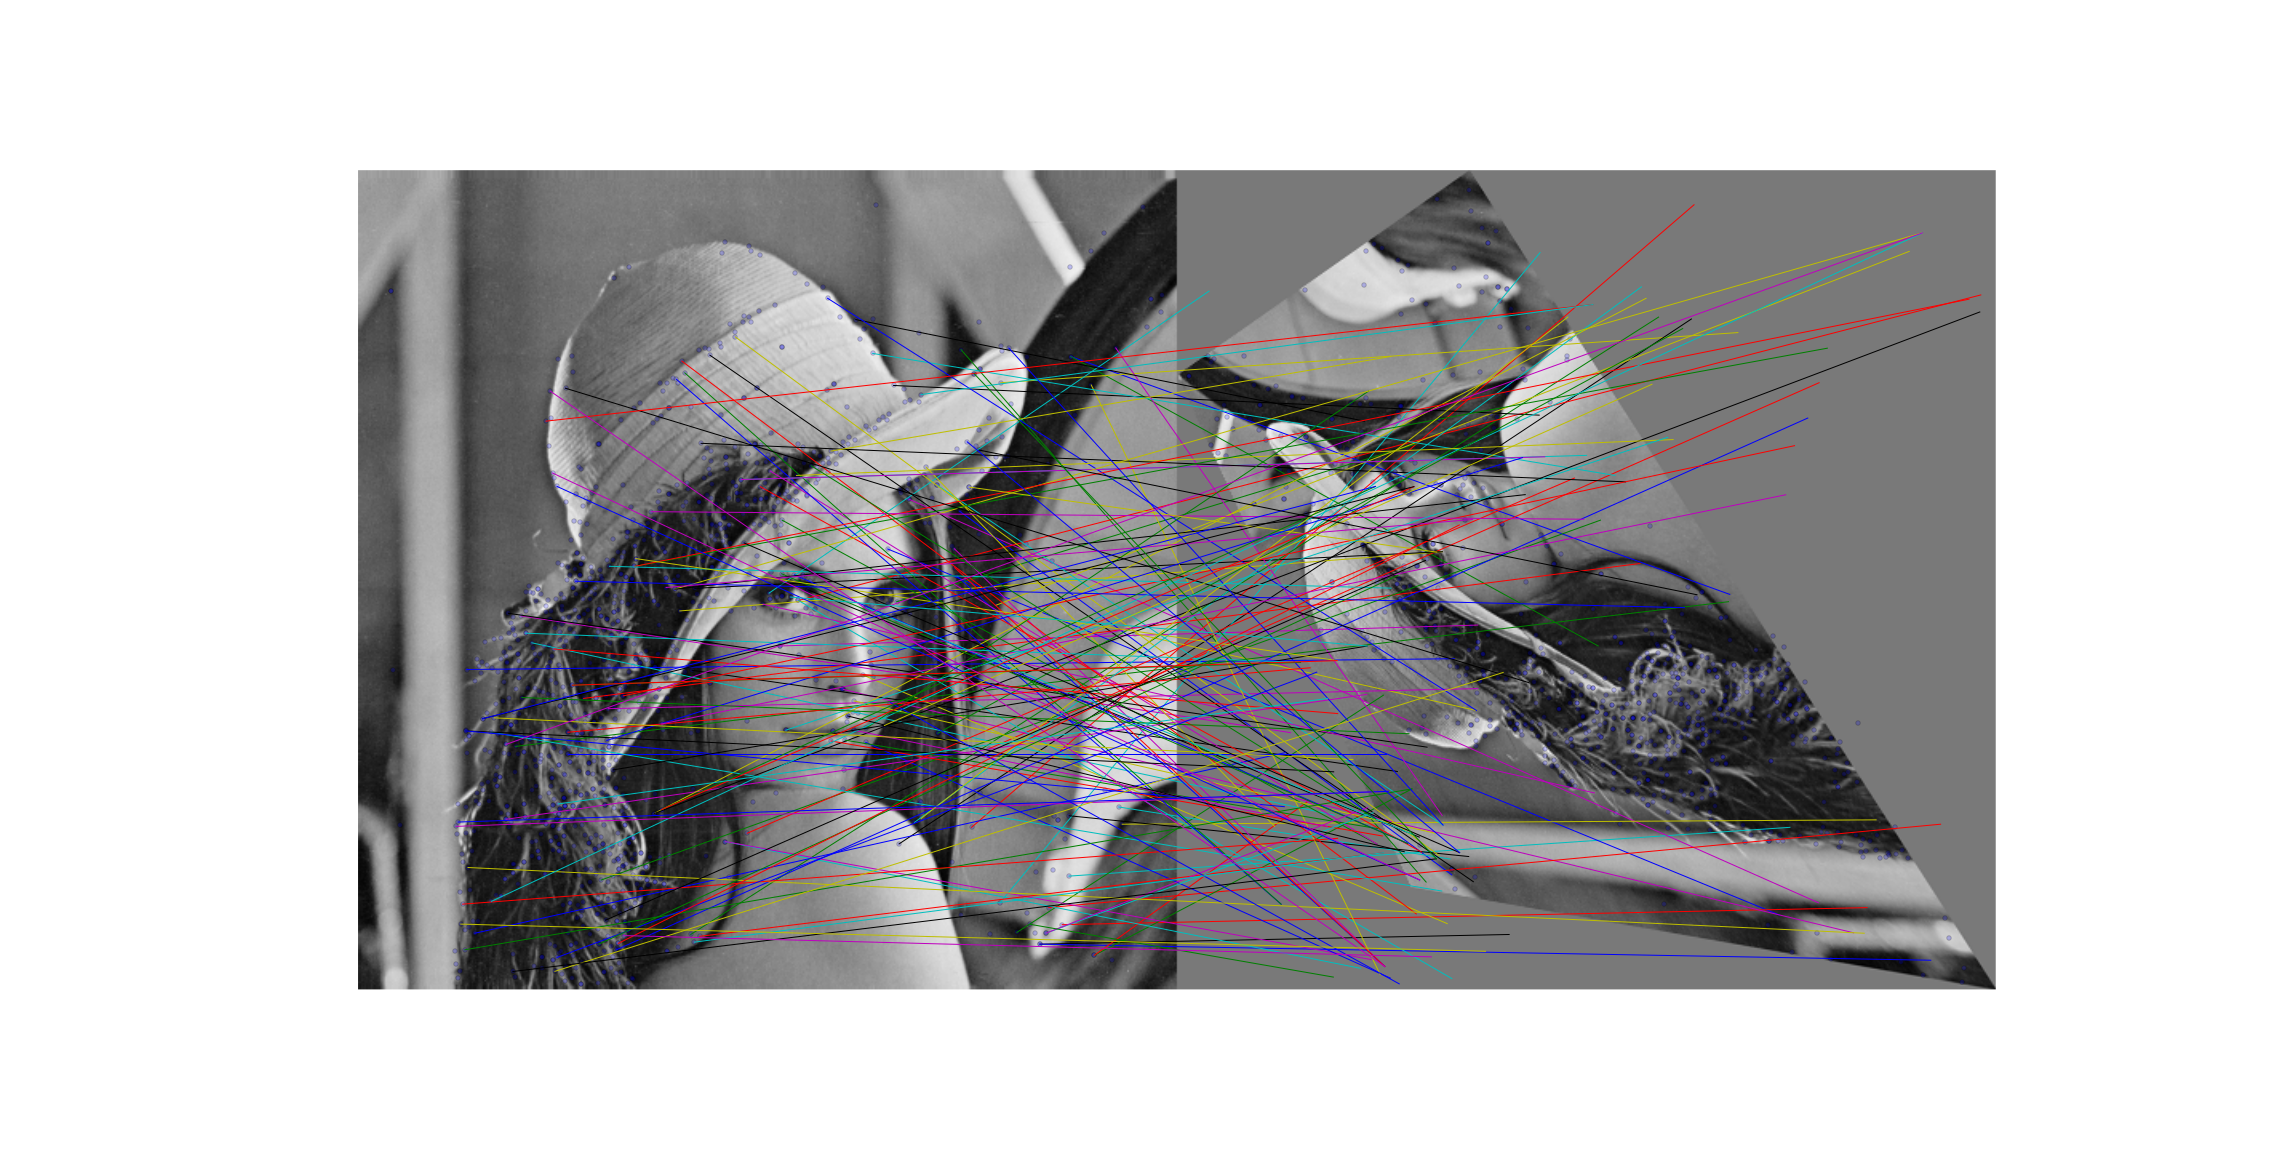

In [46]:
# Aufgabe 4
# solution by david
desc = pandas.read_csv("desc_Lenna.csv", header=None).as_matrix()
desc_trans = pandas.read_csv("desc_Lenna_transformed.csv", header=None).as_matrix()


f, ax = plt.subplots(ncols=1)
f.set_size_inches(32, 32)

ax.imshow(I_comb, cmap=plt.get_cmap('gray'))

ax.scatter(locs[:, 1] + 0, locs[:, 0], alpha=.2)
ax.scatter(locs_trans[:, 1] + I.shape[1], locs_trans[:, 0], alpha=.2)

for i in range(desc.shape[0]):
    descriptor = desc[i,:]
    location = locs[i, :]
    
    diffs = desc_trans - descriptor
    norms = np.linalg.norm(diffs, axis=1)
    
    match_order = np.argsort(norms)
    match_index = match_order[0]
    best_distance = norms[match_index]
    second_best = norms[match_order[1]]
    ratio = best_distance / second_best
    magic_ratio_threshold = .8
    if ratio > magic_ratio_threshold:
        continue
    target_location = locs[match_index, :]
    plt.plot((location[1], I.shape[1] + target_location[1]), 
            (location[0], target_location[0]))

plt.axis("off")
plt.tight_layout()
plt.show()